In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings

from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langsmith import traceable


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
web_search_tool = TavilySearchResults(k=3)

In [4]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    question : str
    generation : str
    web_search : str #whether to run web search or not
    documents : str #the concatenated list of documents text content (or search results)

In [5]:
import os

# Check if the directory and files are readable
directory = 'rag_docs'
print(os.access(directory, os.R_OK))  # Checks if the directory is readable


True


In [6]:
import os
os.chmod('rag_docs', 0o755)


In [7]:
import os
from langchain_community.document_loaders import UnstructuredMarkdownLoader

markdown_folder_path = "rag_docs"  # Set the path to your folder
documents = []

# Iterate over all .md files in the directory
for file in os.listdir(markdown_folder_path):
    if file.endswith('.md'):
        markdown_path = os.path.join(markdown_folder_path, file)                     #=fast
        loader = UnstructuredMarkdownLoader(markdown_path, mode="single", strategy="precise")
        documents.extend(loader.load())  # Add loaded documents to the list


In [8]:
documents

[Document(metadata={'source': 'rag_docs\\Canarias_vive_otro_día_intenso_de_rescates_con_la_llegada_de_al_menos_580_migrantes_El_Mundo.md'}, page_content="Overview of Migrant Rescues in the Canary Islands\n\nThe Canary Islands have become a critical point for migrant rescues, reflecting the severe humanitarian crisis unfolding in the Atlantic. In 2024, the region witnessed a record number of migrant deaths at sea, with nearly 10,000 lives lost. This tragic statistic underscores the perilous nature of the migration route from West Africa, particularly from Mauritania, which spans approximately 1,000 miles. Despite efforts by the European Union to mitigate migration through economic aid, the number of migrants attempting this dangerous journey continues to rise. Local and international organizations, such as Caminando Fronteras, are actively involved in rescue operations, yet face significant challenges due to the prioritization of migration control over human life. The situation demands 

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200, chunk_overlap=100, add_start_index=True #starting char pos.
    #size of characters for each chunk
    #2nd param: will let us have a little portion of the prev. chunk
    # so in case the key info is in that chunk, we can have a way to get those prev chars if needed 
    
    #
)
all_splits = text_splitter.split_documents(documents)

In [10]:
print(f"length of document chunks generated :{len(all_splits)}")

length of document chunks generated :112


In [13]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
#the so-called chroma database

local_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

import os

persist_dir = "./chroma_db"
os.makedirs(persist_dir, exist_ok=True)

vectorstore = Chroma.from_documents(documents=all_splits, embedding=local_embeddings,
                                    persist_directory="./chroma_db")

In [14]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3},
                                    )

In [15]:
# # testing
# question = "Current State of Diplomatic Relations Between Venezuela and Spain"
# retrieved_docs = retriever.invoke(question) #run such retrieval

In [16]:
# retrieved_docs

In [17]:
# retrieved_docs[0].page_content

In [18]:
from langchain_openai import ChatOpenAI

In [19]:
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

llm_json = ChatOpenAI(
        model="gpt-4o",
        temperature = 0,
        model_kwargs={"response_format": {"type": "json_object"}})

In [20]:
# llm.invoke("hey")

## 1. Building the RAG-WebSearch Graph

It takes all the detailed article reports from the .md folder located at `rag_docs/`

In [217]:
generation_instructions = """
 You are an assistant for question-answering tasks inside a phone call conversation.
 
 
 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Keep the answer concise optimized to reduce latency, in a spoken language style.
    
    Question: {question} 
    Context: {context} 
    
    You must also keep in mind that you're answering questions related with the news of the week, so you must always respond properly connecting the answer with the spoken topics, for which i'll attach below as a brief summary.
"""

In [218]:
docs_grader_instructions = """

    You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.

    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question}
"""

In [237]:
import json

In [238]:
from langchain.schema import Document

@traceable
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    # print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    retrieved_docs = retriever.invoke(question)
    
    context = ' '.join([doc.page_content for doc in retrieved_docs])
    
    return {"documents": context, "question": question}
#

@traceable
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    # print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    context = state["documents"]
    
    
    system_instructions = docs_grader_instructions.format(question=question, document=context)
    messages = [
        {"role": "system", "content": system_instructions},
        # {"role": "user", "content": f": {}"}
    ]   
    grade = json.loads(llm_json.invoke(messages).content)["score"]
    # print(grade)
    
    if grade.lower() == "yes":
        # print("---GRADE: DOCUMENT RELEVANT---")
        return {"documents": context, "question": question, "web_search": "No"}
    else:
        # print("---GRADE: RETRIEVED DOCUMENTS NOT RELEVANT, RUNNING WEB SEARCH INSTEAD---")
        return {"documents": context, "question": question, "web_search": "Yes"}
    

@traceable
def generate(state):
    """
    Generate answer either using RAG on retrieved documents or web search results

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    # print("---GENERATE---")
    question = state["question"]
    context = state["documents"]
    
    system_instructions = generation_instructions.format(question=question, context=context)
    
    messages = [
        {"role": "system", "content": system_instructions},
        # {"role": "user", "content": f": {}"}
    ]    
    answer = llm.invoke(messages).content
     
    return {"documents": context, "question": question, "generation": answer}
#

@traceable
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    # print("---WEB SEARCH---")
    question = state["question"]
    context = state["documents"] if "documents" in state else None

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    #we override the past documents, we add the search results
    
    # if context is not None:
    #     context += f"\n {web_results.page_content}"
    # else:
    #     context = web_results.page_content
    
    context = web_results.page_content
    
    return {"documents": context, "question": question}
#

In [239]:
docs = web_search_tool.invoke({"query": "what is the capital of Spain?"})
web_results = "\n".join([d["content"] for d in docs])
web_results = Document(page_content=web_results)

In [240]:
web_results.page_content

'Why Is Madrid the Capital of Spain? Uncharted Territories Why Is Madrid the Capital of Spain? Why Is Madrid the Capital of Spain? Uncharted Territories Why Is Madrid the Capital of Spain? When Madrid became the capital of Spain in 1561, it was not the biggest city in the country. The guy who decided Madrid would be the capital of Spain was Philip II—one of the most powerful kings the country has ever had, who ruled in the 1500s. Following a similar path—helped by a bit of luck due to Philip II’s tastes—is how Madrid transformed from a small backwater city into the second largest city and metropolitan area in the European Union—only after Paris—and a global capital.\nBelow you can find useful information about Madrid, including facts, main attractions and free time activities available. Madrid is the capital of Spain, and is home to the Spanish Royal family as well as the Spanish Government. The city is full of great monuments, like the royal palace, the Plaza Mayor or the many statuet

In [241]:
state = {
    "question": "How much does a tomato cost in San Francisco compared to Spain?",
    "documents": "In San Francisco, the price of 1 lb of tomatoes is $3.74, while in Spain, it is €1.09."
}

# Call the generate function with the simulated state
result = generate(state)

In [242]:
result

{'documents': 'In San Francisco, the price of 1 lb of tomatoes is $3.74, while in Spain, it is €1.09.',
 'question': 'How much does a tomato cost in San Francisco compared to Spain?',
 'generation': "In San Francisco, a pound of tomatoes costs $3.74, while in Spain, it's €1.09. With the current exchange rates, tomatoes are generally more expensive in San Francisco than in Spain. This price difference might be interesting to consider, especially with ongoing discussions about global food prices and inflation."}

In [243]:
import json

In [244]:
generation_grader_instructions = """
    You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation.
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    
    Here is the generated answer: \n\n {generation} \n\n
"""

answer_grader_instructions = """

    You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    
    Here is the generated answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the original user question: {question}
"""

In [245]:
# ' '.join([doc.page_content for doc in web_results])

In [246]:
# GraphState(question=question, generation="", web_search="", documents=web_results.page_content)

In [247]:
@traceable
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generated response is grounded in the document and answers the question.
    
    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    # print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    context = state["documents"] #it can be either the retrieved docs or the web search results
    generation = state["generation"]
    
    
    generation_grader_prompt = generation_grader_instructions.format(documents=context,
                                                                     generation=generation)
    answer_grader_prompt = answer_grader_instructions.format(generation=generation, question=question)
    
    
    messages = [
        {"role": "system", "content": generation_grader_prompt},
        # {"role": "user", "content": f": {}"}
    ]   
    grade = json.loads(llm_json.invoke(messages).content)["score"]
    # print(grade)
    
    if grade.lower() == "yes": #the answer is grounded in the documents
        
    
        #now, we check such generation correctly answers the question
        messages = [
            {"role": "system", "content": answer_grader_prompt},
            # {"role": "user", "content": f": {}"}
        ]    
        
        grade = json.loads(llm_json.invoke(messages).content)["score"]
        
        if grade.lower() == "yes":
            # print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS, AND IT ANSWERS THE QUESTION---")
            return "useful"
        
        
        else:
            # print("---DECISION: GENERATION DOES NOT ANSWER THE QUESTION, RUNNING WEBSEARCH---")
            return "not_useful" #then we simply retry the websearch (only)
        
    else:
        #IF THE MODEL HALLUCINATES, WE RE-RUN ONLY THE GENERATION
        
        # print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not_grounded"


In [248]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

In [249]:
# Define the nodes
workflow.add_node("retrieve", retrieve) 
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("websearch", web_search) 
workflow.add_node("generate", generate)
# workflow.add_node("grade_generation", grade_generation_v_documents_and_question)

In [250]:
@traceable
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    # print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        return "websearch"
    else:
        return "generate"

In [251]:
workflow.set_entry_point("retrieve")

workflow.add_edge("retrieve", "grade_documents")



workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate, #after running grade_documents, we get the key of websearch to know if we run it or not
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)

workflow.add_edge("websearch", "generate") #after web search, we go directly to generation



workflow.add_conditional_edges( #conditional edges
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not_grounded": "generate", #if the llm generation grader result is = "not supported", then re-try
        "useful": END, #if it is useful, then end the process
        "not_useful": "websearch", #if not useful, then run websearch
    },
)

In [252]:
app = workflow.compile()

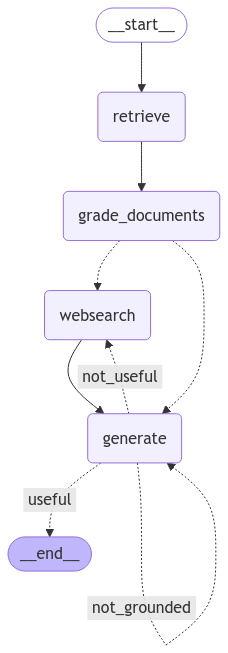

In [253]:
from IPython.display import Image

display(Image(app.get_graph(xray=1).draw_mermaid_png(
)))

### 1.1 Some testing (standalone graph Q-A)

In [254]:
import pyttsx3
import speech_recognition as sr

________

## Baseline facil integrando el grafo y grabamos DEMO y pedimos EVM.CAPITAL

In [256]:
from langgraph.checkpoint.sqlite import SqliteSaver

In [257]:
from contextlib import ExitStack

stack = ExitStack()
memory = stack.enter_context(SqliteSaver.from_conn_string(":memory:"))

In [258]:
app = workflow.compile(checkpointer=memory)

In [ ]:
thread = {"configurable": {"thread_id":"1"}}

app.invoke({"question": "Hey, I want to know the last"}, thread)

{'question': 'What is the capital of Spain?',
 'generation': 'The capital of Spain is Madrid.',
 'web_search': 'Yes',
 'documents': 'Madrid is the capital of Spain.\nWhy Is Madrid the Capital of Spain? Uncharted Territories Why Is Madrid the Capital of Spain? Why Is Madrid the Capital of Spain? Uncharted Territories Why Is Madrid the Capital of Spain? When Madrid became the capital of Spain in 1561, it was not the biggest city in the country. The guy who decided Madrid would be the capital of Spain was Philip II—one of the most powerful kings the country has ever had, who ruled in the 1500s. Following a similar path—helped by a bit of luck due to Philip II’s tastes—is how Madrid transformed from a small backwater city into the second largest city and metropolitan area in the European Union—only after Paris—and a global capital.\nBelow you can find useful information about Madrid, including facts, main attractions and free time activities available. Madrid is the capital of Spain, and i

In [268]:
from pprint import pprint
inputs = {"question": "Hey, I want to know the last"}
for output in app.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: retrieve:'
'Finished running: grade_documents:'
'Finished running: websearch:'
'Finished running: generate:'
'Finished running: generate:'
'Finished running: generate:'
'Finished running: generate:'
'Finished running: generate:'
'Finished running: generate:'
'Finished running: generate:'
'Finished running: websearch:'
'Finished running: generate:'
'Finished running: generate:'


KeyboardInterrupt: 

_____________________

In [264]:
import keyboard
import os
import tempfile

import numpy as np
import openai
import sounddevice as sd
import soundfile as sf
import tweepy

# from elevenlabs import generate, play, set_api_key
# from langchain.agents import initialize_agent, load_tools
# from langchain.agents.agent_toolkits import ZapierToolkit
from langchain_openai import ChatOpenAI
from langchain.memory import ConversationBufferMemory
# from langchain.tools import BaseTool
# from langchain.utilities.zapier import ZapierNLAWrapper

from elevenlabs.client import ElevenLabs
from elevenlabs import Voice, VoiceSettings, play

from dotenv import load_dotenv
import os

from openai import OpenAI
openai_client = OpenAI()

load_dotenv()

# set_api_key(os.getenv("ELEVEN_API_KEY"))
# openai.api_key = os.get("OPENAI_API_KEY")

# Set recording parameters
duration = 5  # duration of each recording in seconds
fs = 44100  # sample rate
channels = 1  # number of channels


def record_audio(duration, fs, channels):
    print("Recording...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=channels)
    sd.wait()
    print("Finished recording.")
    return recording


def transcribe_audio(recording, fs):
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_audio:
        sf.write(temp_audio.name, recording, fs)
        temp_audio.close()
        with open(temp_audio.name, "rb") as audio_file:
            # transcript = openai.Audio.transcribe("whisper-1", audio_file)
            transcription = openai_client.audio.transcriptions.create(
                model="whisper-1", 
                file=audio_file, 
                response_format="text"
            )
        os.remove(temp_audio.name)
    return transcription


client = ElevenLabs(
    api_key=os.getenv("XI_API_KEY")  # Load API key from environment variable
)

def play_generated_audio(text):

    # Generate the audio response using Eleven Labs API
    # audio = client.generate(
    #     text=text,
    #     voice="Aria",  # You can replace "Aria" with any other voice ID or name
    #     model="eleven_multilingual_v2",  # Specify the model version to use
    #     stream=True,
    #     voice_settings={
    #         "stability": 0.8,  # Adjust stability (0.0 - 1.0)
    #         "similarity_boost": 0.75  # Adjust the likeness to the selected voice
    #     }
    # )
    # play(audio)
    
    response = openai_client.audio.speech.create(
        model="tts-1",
        voice="nova",
        input=text
    )

    if hasattr(response, 'content') and response.content:
        # Use your play function to play the audio instantly
        play(response.content)
    elif hasattr(response, 'url'):
        # If the API provides a URL, use your play function to play the audio from URL
        audio_url = response.url
        play(audio_url)
    else:
        print("No valid audio content found in the response.")    

In [266]:
q = False

while q!=True:
    print("Press spacebar to start recording.")
    # keyboard.wait("space")  # wait for spacebar to be pressed
    
    val = input("Type any key or q to exit: ")
   
   
    if val != "q":
         recorded_audio = record_audio(duration, fs, channels)
         message = transcribe_audio(recorded_audio, fs)
         print(f"You: {message}")
        # assistant_message = agent.run(message)
         assistant_message = app.invoke({"question":message}, thread).content
        
         play_generated_audio(assistant_message)
    else:
        q = True
    

Press spacebar to start recording.
Recording...
Finished recording.
You: Hey, I want to know the last



GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [255]:
import asyncio
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph
from contextlib import AsyncExitStack

# Assuming 'graph' is already defined and compiled previously in your code

async def stream_events_for_user_query():
    while True:
        # Continuously ask for user input
        query = input("Enter your question (or type 'exit' to stop): ")
        
        if query.lower() == 'exit':
            print("Exiting...")
            break

        # Define the thread configuration
        thread = {"configurable": {"thread_id": "4"}}

        # Stream events from the graph
        async for event in app.astream_events({"question": query}, thread, version="v1"):
            kind = event["event"]

            # Real-time token streaming
            if kind == "on_chat_model_stream":
                content = event["data"]["chunk"].content
                if content:
                    print(content, end="|")

# In Jupyter, directly await the stream_events_for_user_query function
await stream_events_for_user_query()

{"|score|":| "|yes|"}|This| week|,| Venezuela|'s| political| situation| is| tense|,| with| accusations| against| an| Argentine| officer| for| terrorism|,| which| has| strained| relations| between| the| two| countries|.| Additionally|,| Venezuel|an| opposition| members| are| reportedly| ho|led| up| in| the| Argentine| embassy|,| describing| it| as| a| '|pr|ison|.'| These| events| highlight| the| fragile| political| stability| and| potential| for| increased| military| involvement| in| Venezuela|.|{"|score|":| "|yes|"}|{"|score|":| "|yes|"}|Exiting...


In [ ]:
from pprint import pprint
inputs = {"question": "how many PIB points did Spain lose in 2020?", "recursion_limit":4}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

In [45]:
inputs = {"question": "What is prompt engineering?"}

v = app.invoke(inputs)

In [47]:
v["generation"].content

'Prompt engineering is a discipline focused on designing and optimizing prompts to enhance the performance and reliability of AI models, particularly large language models (LLMs). It involves techniques such as fine-tuning models on specific tasks and crafting inputs that elicit desired responses by leveraging context, examples, and different prompt formats. Prompt engineering is crucial for improving the capacity of LLMs across various tasks, such as question answering, creative writing, and arithmetic reasoning.'

In [40]:
from pprint import pprint
inputs = {"question": "What is prompt engineering?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

'Finished running: retrieve:'
'Finished running: grade_documents:'


KeyboardInterrupt: 